In [ ]:
import requests
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from scipy.stats import mannwhitneyu # one-sided
from scipy.stats import ranksums # two-sided
from scipy.stats import spearmanr # he Spearman rank correlation coefficient is a non-parametric measure of correlation, which means it does not make assumptions about the distribution of the data or the linearity of the relationship.
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Download the XLSX file from the website
tz_name = ['metabolite',
           'metadata',
           'pathways',
           'species',
           'cytokines']

nl_name = ['metadata',
           'pathways',
           'species',
           'cytokines']

nl_dict = {name: {} for name in nl_name}
tz_dict = {name: {} for name in tz_name}

print("TZ")
for idx, name in enumerate(tz_name):
    url = f'https://raw.githubusercontent.com/ziyuw2/20.440_project/master/Data/tz_{name}.xlsx'
    response = requests.get(url)
    with open('source.xlsx', 'wb') as f:
        f.write(response.content)
    # Read the Excel file into a Pandas DataFrame
    source_exl = pd.read_excel('source.xlsx', sheet_name=None, engine='openpyxl')
    print(f'Data name: {name}')
    for sheet_name, content in source_exl.items():
        tz_dict[name][sheet_name] = content
        print(f'Sheets in the xlsx: {sheet_name}')

print("NL")
for idx, name in enumerate(nl_name):

    url = f'https://raw.githubusercontent.com/ziyuw2/20.440_project/master/Data/nl_{name}.xlsx'
    response = requests.get(url)
    with open('source.xlsx', 'wb') as f:
        f.write(response.content)
    # Read the Excel file into a Pandas DataFrame
    source_exl = pd.read_excel('source.xlsx', sheet_name=None, engine='openpyxl')
    print(f'Data name: {name}')
    for sheet_name, content in source_exl.items():
        nl_dict[name][sheet_name] = content
        print(f'Sheets in the xlsx: {sheet_name}')

TZ
Data name: metabolite
Sheets in the xlsx: metabolite
Sheets in the xlsx: metadata
Data name: metadata
Sheets in the xlsx: all
Sheets in the xlsx: diet
Data name: pathways
Sheets in the xlsx: pathways
Sheets in the xlsx: metadata
Data name: species
Sheets in the xlsx: species
Sheets in the xlsx: species_lm
Sheets in the xlsx: metadata_lm
Data name: cytokines
Sheets in the xlsx: cytokines
Sheets in the xlsx: metadata
NL
Data name: tracker
Sheets in the xlsx: tracker
Data name: metadata
Sheets in the xlsx: metadata
Data name: pathways
Sheets in the xlsx: pathways
Sheets in the xlsx: metadata
Data name: species
Sheets in the xlsx: species
Sheets in the xlsx: metadata
Data name: cytokines
Sheets in the xlsx: cytokines
Sheets in the xlsx: metadata


In [ ]:
tz_diet = pd.merge(tz_dict['metadata']['diet'], tz_dict['metadata']['all'][['ID','Residency_Area']], on='ID', how='left')
species_tz = pd.merge(tz_dict['species']['species_lm'], tz_dict['metadata']['all'][['ID','Residency_Area']], on='ID', how='left')
species_tz = pd.merge(species_tz, tz_dict['metadata']['diet'][['ID','exc rice']], on='ID', how='left')
species_nl = nl_dict['species']['species']
species_nl = species_nl.rename(columns={'row': 'ID'})

## Fig. 6

In [ ]:
tz_path = tz_dict['pathways']['pathways']
path_meta = tz_dict['pathways']['metadata']
path_meta_filtered = path_meta[~path_meta['Label'].str.contains('g__')] # getting rid of all the species specific pathways
path_notation = path_meta_filtered['pathways'].tolist()
id_path = ['ID'] + path_notation
path_select = tz_path[id_path]
species_path = species_tz[['ID', 'Akkermansia.muciniphila', 'Bifidobacterium.longum', 'Prevotella.copri','Residency_Area', 'exc rice']]
species_path = pd.merge(species_path, path_select, on='ID', how='left')
path_pca = species_path.drop(['ID', 'Akkermansia.muciniphila', 'Bifidobacterium.longum', 'Prevotella.copri','Residency_Area', 'exc rice'], axis=1)

In [ ]:
cov_matrix = np.cov(path_pca, rowvar=False)
eigenvalues, _ = np.linalg.eig(cov_matrix)

# Sort the eigenvalues in descending order
eigenvalues_sorted = np.sort(eigenvalues)[::-1]

# Calculate the cumulative proportion of variance explained by each eigenvalue
total_variance = np.sum(eigenvalues)
variance_explained = eigenvalues_sorted / total_variance
cumulative_variance_explained = np.cumsum(variance_explained)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


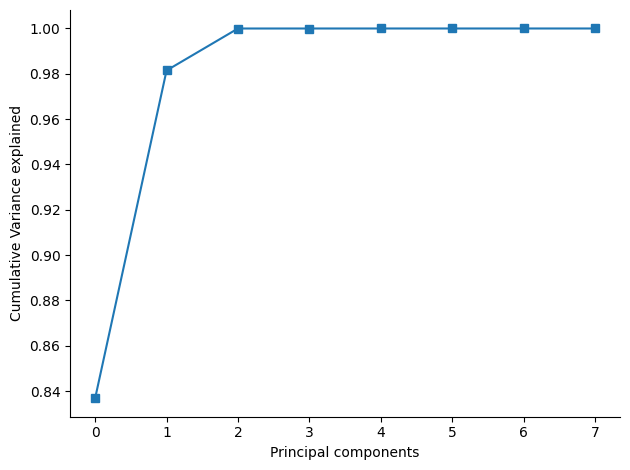

In [ ]:
# Plot the scree plot
fig, ax = plt.subplots()
plt.plot(cumulative_variance_explained[0:8], 's-', label='Cumulative variance explained')
plt.xlabel('Principal components')
plt.ylabel('Cumulative Variance explained')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.set_tight_layout(True)
plt.show()
# fig.savefig(f'/content/drive/MyDrive/2023 Spring Courses/20.440/20.440 Final Project/ziyu_figures/cpc_tz', format='png', dpi=600)

In [ ]:
scaler = StandardScaler()
path_scaled = scaler.fit_transform(path_pca)
pca = PCA(n_components = 2)  # 2 pcs explain almost 100% variance
pca.fit(path_scaled)
path_pcs = pca.transform(path_scaled)
species_path = pd.concat([species_path, pd.DataFrame(path_pcs, columns=['pc1', 'pc2'])], axis=1)

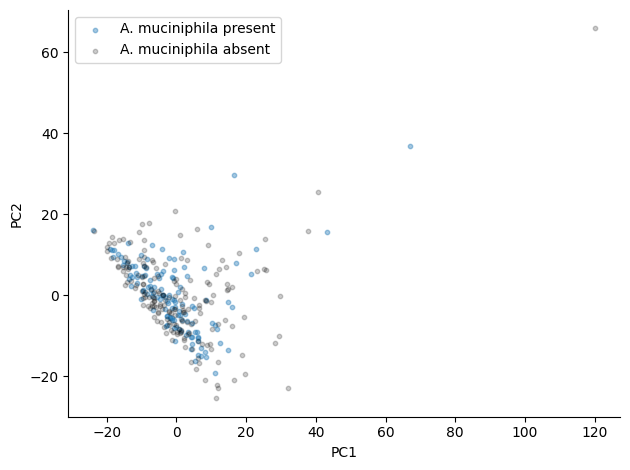

In [ ]:
am_pca = species_path.loc[species_path['Akkermansia.muciniphila'] != 0, ['pc1', 'pc2']]
noam_pca = species_path.loc[species_path['Akkermansia.muciniphila'] == 0, ['pc1', 'pc2']]
fig, ax = plt.subplots()
plt.scatter(am_pca['pc1'], am_pca['pc2'], s=10, alpha = 0.4, label='A. muciniphila present',c='tab:blue')
plt.scatter(noam_pca['pc1'], noam_pca['pc2'], s=10, alpha=0.2, label='A. muciniphila absent',c='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.set_tight_layout(True)
# plt.gca().set_aspect('equal')
plt.show()
# fig.savefig('/content/drive/MyDrive/2023 Spring Courses/20.440/20.440 Final Project/ziyu_figures/pc_tz_am', format='png', dpi=600)

In [ ]:
pc1_loadings = pca.components_[0]
pc2_loadings = pca.components_[1]

features = path_select.columns.tolist()[1:] # the first column is ID
loadings_df = pd.DataFrame({'Feature': features, 'PC1 Loadings': pc1_loadings, 'PC2 Loadings': pc2_loadings})

# Sort the features by the absolute value of their PC1 loadings in descending order
loadings_df['PC1 Loadings Abs'] = np.abs(loadings_df['PC1 Loadings'])
loadings_df = loadings_df.sort_values(by=['PC1 Loadings Abs'], ascending=False)
print(loadings_df.head(10))

           Feature  PC1 Loadings  PC2 Loadings  PC1 Loadings Abs
204  pathways_2048      0.065151      0.037089          0.065151
16    pathways_389      0.063729      0.008306          0.063729
1       pathways_2      0.063121     -0.012588          0.063121
484  pathways_5352      0.062462      0.023058          0.062462
33    pathways_596      0.062368      0.039394          0.062368
729  pathways_8026      0.062201      0.020261          0.062201
113  pathways_1404      0.062135      0.033698          0.062135
398  pathways_4060      0.061929      0.043057          0.061929
129  pathways_1494      0.061457      0.031434          0.061457
796  pathways_8647      0.061419      0.040446          0.061419


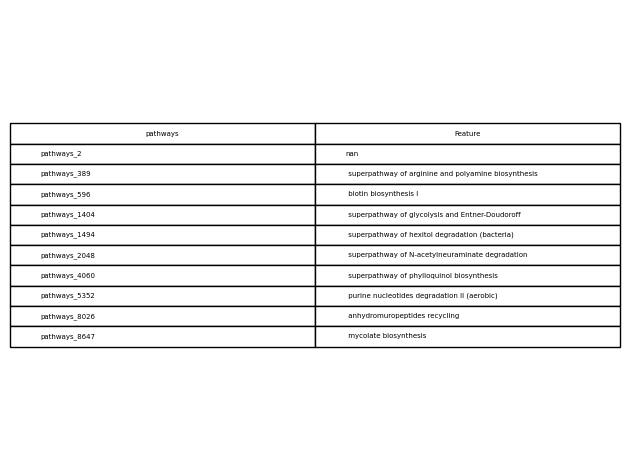

,pathways,Feature
1,pathways_2,NaN
388,pathways_389,superpathway of arginine and polyamine biosyn...
595,pathways_596,biotin biosynthesis I
1403,pathways_1404,superpathway of glycolysis and Entner-Doudoroff
1493,pathways_1494,superpathway of hexitol degradation (bacteria)
2047,pathways_2048,superpathway of N-acetylneuraminate degradation
4059,pathways_4060,superpathway of phylloquinol biosynthesis
5351,pathways_5352,purine nucleotides degradation II (aerobic)
8025,pathways_8026,anhydromuropeptides recycling
8646,pathways_8647,mycolate biosynthesis


In [ ]:
pathway_names = path_meta.loc[path_meta['pathways'].isin(loadings_df['Feature'][0:10].tolist()), ['pathways', 'Feature']]
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
ax.table(cellText=pathway_names.values, colLabels=pathway_names.columns, loc='center', cellLoc='left')
plt.tight_layout()
plt.show()
# fig.savefig('/content/drive/MyDrive/2023 Spring Courses/20.440/20.440 Final Project/ziyu_figures/loading_tz', format='png', dpi=600)
pathway_names

The Spearman rank correlation coefficient between Akk and ..pathways is  -0.14403196506962881
p-value: 0.010481975420277595
The Spearman rank correlation coefficient between Bif and ..pathways is  -0.048648221497070224
p-value: 0.3895149465112363
The Spearman rank correlation coefficient between Pre and ..pathways is  0.061213262701850076
p-value: 0.27875314899988707


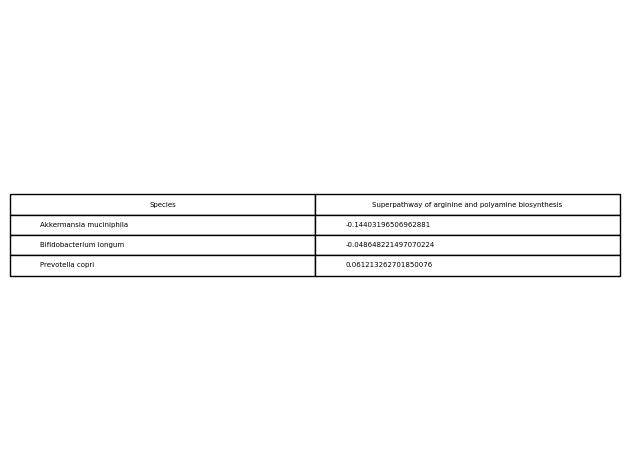

In [ ]:
spear_corr = []
spear_p = []
corr, p_value = spearmanr(species_path['Akkermansia.muciniphila'], species_path['pathways_389'])
spear_corr.append(corr)
spear_p.append(p_value)
print("The Spearman rank correlation coefficient between Akk and ..pathways is ", corr)
print("p-value:", p_value)

corr, p_value = spearmanr(species_path['Bifidobacterium.longum'], species_path['pathways_389'])
spear_corr.append(corr)
spear_p.append(p_value)
print("The Spearman rank correlation coefficient between Bif and ..pathways is ", corr)
print("p-value:", p_value)

corr, p_value = spearmanr(species_path['Prevotella.copri'], species_path['pathways_389'])
spear_corr.append(corr)
spear_p.append(p_value)
print("The Spearman rank correlation coefficient between Pre and ..pathways is ", corr)
print("p-value:", p_value)

spear_path = {'Species': ['Akkermansia muciniphila', 'Bifidobacterium longum', 'Prevotella copri'],
              "Superpathway of arginine and polyamine biosynthesis": spear_corr}
spear_path = pd.DataFrame(spear_path)

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
ax.table(cellText=spear_path.values, colLabels=spear_path.columns, loc='center', cellLoc='left')
plt.tight_layout()
plt.show()
# fig.savefig('/content/drive/MyDrive/2023 Spring Courses/20.440/20.440 Final Project/ziyu_figures/spear_path', format='png', dpi=600)

In [ ]:
corr, p_value = spearmanr(species_path['exc rice'], species_path['pathways_389'])
print("The Spearman rank correlation coefficient between diet fiber and ..pathways is ", corr)
print("p-value:", p_value)

The Spearman rank correlation coefficient between diet fiber and ..pathways is  0.08122732131726537
p-value: 0.1503522730656805
